# Sequence Processing with HMMs and CRFs

**The goal of this practical is to study sequence models in NLP.**

We will work on Part-Of-Speech (POS) and optionally on chunking (gathering different groups in sentences). The datasets are from [CONLL 2000](https://www.clips.uantwerpen.be/conll2000/chunking/): 
- **Small corpus:** chtrain/chtest to understand the tools and models 
- **Larger corpus:** train/test to collect reliable experimental results


# 1) HMMS


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter


In [2]:
# Loading POS/Chunking data
def load(filename):
    listeDoc = list()
    with open(filename, "r") as f:
        doc = list()
        for ligne in f:
            if len(ligne) < 2: # fin de doc
                listeDoc.append(doc)
                doc = list()
                continue
            mots = ligne.replace("\n","").split(" ")
            doc.append((mots[0],mots[1])) # Change mots[1] -> mots[2] for chuncking
    return listeDoc

In [3]:
# =============== loding ============
# small corpus => ideal for first tests
filename = "../ressources/conll2000/chtrain.txt" 
filenameT = "../ressources/conll2000/chtest.txt" 

# Larger corpus => To valide perf.
# filename = "../ressources/conll2000/train.txt" 
# filenameT = "../ressources/conll2000/test.txt" 

alldocs = load(filename)
alldocsT = load(filenameT)

print(len(alldocs)," docs read")
print(len(alldocsT)," docs (T) read")

823  docs read
77  docs (T) read


In [4]:
print(alldocs[0])
print(alldocsT[0])

[('Rockwell', 'NNP'), ('International', 'NNP'), ('Corp.', 'NNP'), ("'s", 'POS'), ('Tulsa', 'NNP'), ('unit', 'NN'), ('said', 'VBD'), ('it', 'PRP'), ('signed', 'VBD'), ('a', 'DT'), ('tentative', 'JJ'), ('agreement', 'NN'), ('extending', 'VBG'), ('its', 'PRP$'), ('contract', 'NN'), ('with', 'IN'), ('Boeing', 'NNP'), ('Co.', 'NNP'), ('to', 'TO'), ('provide', 'VB'), ('structural', 'JJ'), ('parts', 'NNS'), ('for', 'IN'), ('Boeing', 'NNP'), ("'s", 'POS'), ('747', 'CD'), ('jetliners', 'NNS'), ('.', '.')]
[('Confidence', 'NN'), ('in', 'IN'), ('the', 'DT'), ('pound', 'NN'), ('is', 'VBZ'), ('widely', 'RB'), ('expected', 'VBN'), ('to', 'TO'), ('take', 'VB'), ('another', 'DT'), ('sharp', 'JJ'), ('dive', 'NN'), ('if', 'IN'), ('trade', 'NN'), ('figures', 'NNS'), ('for', 'IN'), ('September', 'NNP'), (',', ','), ('due', 'JJ'), ('for', 'IN'), ('release', 'NN'), ('tomorrow', 'NN'), (',', ','), ('fail', 'VB'), ('to', 'TO'), ('show', 'VB'), ('a', 'DT'), ('substantial', 'JJ'), ('improvement', 'NN'), ('from'

## Building a baseline POS model (without sequence)

We will build a simple dictionary ```word => PoS label``` without taking into account any sequence information. We will compare the sequence models to this baseline.

The dataset is a list a tuples with ```(word, POS)```. **Build a simple dictionary mapping each word to its PoS tag in the train set**

In [5]:
# Dictionary building 
def get_dico(alldocs):
    dicoTrain = dict()

    for document in alldocs:
        for couple in document:
            if(couple[0] not in dicoTrain.keys()):
                dicoTrain[couple[0]]=[couple[1]]
            else:
                list_pos = dicoTrain.get(couple[0])
                list_pos.append(couple[1])
                dicoTrain[couple[0]]=list_pos
    return dicoTrain
dicoTrain= get_dico(alldocs)        
print(len(dicoTrain), "mots")
print(dicoTrain)

4569 mots
{'Rockwell': ['NNP', 'NNP', 'NNP', 'NNP'], 'International': ['NNP', 'JJ', 'NNP'], 'Corp.': ['NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP'], "'s": ['POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'VBZ', 'VBZ', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', '

In [6]:
def get_elt_majoritaire(dico):
    all_pos=[]
    for key, value in dico.items():
        for elem in value:
            all_pos.append(elem)
            

    compteur = Counter(all_pos)
    elt_majoritaire = max(compteur, key=compteur.get)
    #print(set(all_pos))
    
    return elt_majoritaire

pos_maj = get_elt_majoritaire(dicoTrain)
pos_maj

'NN'

In [7]:
def get_dico_uniquePos(dicoTrain) :   
    dicoTrain_uniquePos=dict()
    for k,v in dicoTrain.items():
        #rechercher l'element majoritaire parmi les pos du mot
        compteur = Counter(v)
        pos_majoritaire = max(compteur, key=compteur.get)
        dicoTrain_uniquePos[k]=pos_majoritaire
    return dicoTrain_uniquePos

dicoTrain_uniquePos=get_dico_uniquePos(dicoTrain)
dicoTrain_uniquePos

{'Rockwell': 'NNP',
 'International': 'NNP',
 'Corp.': 'NNP',
 "'s": 'POS',
 'Tulsa': 'NNP',
 'unit': 'NN',
 'said': 'VBD',
 'it': 'PRP',
 'signed': 'VBD',
 'a': 'DT',
 'tentative': 'JJ',
 'agreement': 'NN',
 'extending': 'VBG',
 'its': 'PRP$',
 'contract': 'NN',
 'with': 'IN',
 'Boeing': 'NNP',
 'Co.': 'NNP',
 'to': 'TO',
 'provide': 'VB',
 'structural': 'JJ',
 'parts': 'NNS',
 'for': 'IN',
 '747': 'CD',
 'jetliners': 'NNS',
 '.': '.',
 'the': 'DT',
 'calls': 'VBZ',
 'supply': 'VB',
 '200': 'CD',
 'additional': 'JJ',
 'so-called': 'JJ',
 'shipsets': 'NNS',
 'planes': 'NNS',
 'These': 'DT',
 'include': 'VB',
 ',': ',',
 'among': 'IN',
 'other': 'JJ',
 'each': 'DT',
 'jetliner': 'NN',
 'two': 'CD',
 'major': 'JJ',
 'bulkheads': 'NNS',
 'pressure': 'NN',
 'floor': 'NN',
 'torque': 'NN',
 'box': 'NN',
 'fixed': 'VBN',
 'leading': 'VBG',
 'edges': 'NNS',
 'wings': 'NNS',
 'and': 'CC',
 'an': 'DT',
 'aft': 'JJ',
 'keel': 'NN',
 'beam': 'NN',
 'Under': 'IN',
 'existing': 'VBG',
 'has': 'VBZ'

**Note: on the test set, there are unknown words...**. We will use the following simple strategy: 
```
# remplace
dico[cle] # crashing with an unknown key 
# by 
dico.get(cle, DefaultValue)
```
From a linguistic point of view, we can choose the default value as the majority PoS class, producing a stronger baseline.

In [8]:
def check_prediction(dicoTrain_uniquePos, alldocsT):
    cpt=0  

    for document in alldocsT:
        
        for k, v in document:
            if k in dicoTrain_uniquePos.keys():
                if v == dicoTrain_uniquePos[k]:
                    cpt +=1
                
            else:
                if v == pos_maj:
                    cpt +=1
                
    return cpt

def check_accuracy(dicoTrain_uniquePos, alldocsT):
    cpt = check_prediction(dicoTrain_uniquePos, alldocsT)
    nb = 0
    for doc in alldocsT:
        nb += len(doc)
    
    return cpt/nb


In [9]:
print(check_prediction(dicoTrain_uniquePos, alldocsT))
check_accuracy(dicoTrain_uniquePos, alldocsT)

1549


0.8169831223628692

Check: 1433 good predictions in test over 1896

(1527 with 'NN' as default PoS value)

## HMMs

Here is a code for training HMM parameters and running decoding using the Viterbi algorithm. You should apply it to our PoS task. **N.B.: you should undersand the ```eps``` parmaters**.


In [10]:
# allx: list of observation sequences 
# allq: list os state sequences 
# N: nb states
# K: nb observations

def learnHMM(allx, allq, N, K, initTo1=True):
    if initTo1:
        eps = 1e-1 # You can play with this regularization parameter default 1e-3
        A = np.ones((N,N))*eps
        B = np.ones((N,K))*eps
        Pi = np.ones(N)*eps
    else:
        A = np.zeros((N,N))
        B = np.zeros((N,K))
        Pi = np.zeros(N)
    
    for x,q in zip(allx,allq):
        Pi[int(q[0])] += 1
        for i in range(len(q)-1):
            A[int(q[i]),int(q[i+1])] += 1
            B[int(q[i]),int(x[i])] += 1
        B[int(q[-1]),int(x[-1])] += 1 # last transition
    A = A/np.maximum(A.sum(1).reshape(N,1),1) # normalisation
    B = B/np.maximum(B.sum(1).reshape(N,1),1) # normalisation
    Pi = Pi/Pi.sum()
    return Pi , A, B

def viterbi(x,Pi,A,B):
    T = len(x)
    N = len(Pi)
    logA = np.log(A)
    logB = np.log(B)
    logdelta = np.zeros((N,T))
    psi = np.zeros((N,T), dtype=int)
    S = np.zeros(T)
    logdelta[:,0] = np.log(Pi) + logB[:,int(x[0])]
    #forward
    for t in range(1,T):
        logdelta[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).max(0) + logB[:,int(x[t])]
        psi[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).argmax(0)
    # backward
    logp = logdelta[:,-1].max()
    S[T-1] = logdelta[:,-1].argmax()
    for i in range(2,T+1):
        S[int(T-i)] = psi[int(S[int(T-i+1)]),int(T-i+1)]
    return S, logp #, delta, psi
 

### Data encoding

We will map each word to an index for traing the HMM (see code below):
```
 The cat is in the garden => 1 2 3 4 1 5
```
We have to understand the dictionary functionning to retrieve the words corresponding to indices.

In [11]:
# alldocs etant issu du chargement des données
# la mise en forme des données est fournie ici
# afin de produire des analyses qualitative, vous devez malgré tout comprendre le fonctionnement des dictionnaires

buf = [[m for m,pos in d ] for d in alldocs]
mots = []
[mots.extend(b) for b in buf]
mots = np.unique(np.array(mots))
nMots = len(mots)+1 # mot inconnu

mots2ind = dict(zip(mots,range(len(mots))))
mots2ind["UUUUUUUU"] = len(mots)

buf2 = [[pos for m,pos in d ] for d in alldocs]
cles = []
[cles.extend(b) for b in buf2]
cles = np.unique(np.array(cles))
cles2ind = dict(zip(cles,range(len(cles))))

nCles = len(cles)

print(nMots,nCles," in the dictionary")

# mise en forme des données
allx  = [[mots2ind[m] for m,pos in d] for d in alldocs]
allxT = [[mots2ind.setdefault(m,len(mots)) for m,pos in d] for d in alldocsT]

allq  = [[cles2ind[pos] for m,pos in d] for d in alldocs]
allqT = [[cles2ind.setdefault(pos,len(cles)) for m,pos in d] for d in alldocsT]

4570 42  in the dictionary


In [12]:
# First doc:
print(allx[0])
print(allq[0])

[1140, 814, 563, 11, 1294, 4393, 3855, 2854, 3992, 1362, 4242, 1452, 2395, 2855, 1990, 4529, 446, 525, 4299, 3595, 4148, 3368, 2499, 446, 11, 283, 2861, 20]
[18, 18, 18, 22, 18, 17, 32, 23, 32, 9, 13, 17, 33, 24, 17, 12, 18, 18, 29, 31, 13, 20, 12, 18, 22, 8, 20, 5]


## You turn: apply HMMs to those data!

In [13]:
# HMM training 
Pi , A, B = learnHMM(allx, allq, nCles, nMots, initTo1=True)


In [14]:
viterbi(allxT[0], Pi, A, B)

(array([41., 12.,  9., 17., 36., 25., 34., 29., 31.,  9., 13., 20., 12.,
        17., 20., 12., 18.,  4., 13., 12.,  9., 17.,  4., 33., 29., 31.,
         9., 13., 17., 12., 18.,  7., 18., 22., 13., 20.,  5.]),
 -260.0537140528326)

In [15]:
# HMM decoding and performances evaluation
def decoder(allxT, allqT, Pi, A, B):
    cpt=0
    n=0
    list_predict = []

    for i in range(len(allxT)):
        
        sequence_predite,_ = viterbi(allxT[i], Pi, A, B)
        list_predict.append(sequence_predite)
        
        for predicted,true in zip(sequence_predite,allqT[i]):
            n+=1
            if predicted == true:
                cpt +=1

    acc = cpt/n
    return list_predict, cpt, acc #le nombre de POS correctement identifiés par viterbi

list_predict, cpt, acc = decoder(allxT, allqT, Pi, A, B)

print("nb predictions correctes avec viterbi:", cpt)
print("précision de la prédiction avec viterbi:", acc)

nb predictions correctes avec viterbi: 1565
précision de la prédiction avec viterbi: 0.82542194092827


Check : 1564 in test

### Qualitative Analyis:

- With imshow on the parameters (ou d'un argsort), show what are the probable transition between labels.
- Visualize the confusion matrices to understand what is challenging in this task
- Find out examples that are corrected by Viterbi decoding



### Matrice de transitions

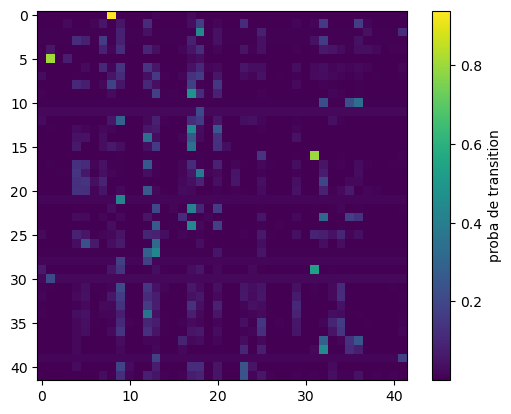

In [16]:
#Matrice de transitions entre labels
plt.imshow(A)
plt.colorbar(label='proba de transition')

### Matrice de confusion

In [17]:
# matrice de confusion

list_labels_uniques = [set(doc) for doc in allqT]

all_labels = set()
for labels in list_labels_uniques:
    all_labels.update(labels)


confusion = np.zeros((nCles+1,nCles+1))

for document_true, document_pred in zip(allqT, list_predict):
    for indice_pos_true, indice_pos_pred in zip(document_true, document_pred):
        confusion[indice_pos_true][indice_pos_pred.astype(int)] +=1

confusion
    


array([[14.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 14.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 13.,  0.],
       [ 6.,  0.,  0., ...,  0.,  0.,  0.]])

### Exemples corrigés par Viterbi

In [18]:
#Pour mapper chaque index au mot/label qui lui correspond
ind2mots =  {v: k for k, v in mots2ind.items()}
ind2cles = {v: k for k, v in cles2ind.items()}

In [19]:
def pos_corriges_viterbi(allxT, dicoTrain_uniquePos, Pi, A, B, ind2mots, ind2cles):
    erreurs_naif = []
    for i in range(len(allxT)):
            
        sequence_predite,_ = viterbi(allxT[i], Pi, A, B)
        j=0
        for predicted_pos_viterbi, true_pos in zip(sequence_predite,allqT[i]):
        
            
            #print((i,j))
            if predicted_pos_viterbi == true_pos:
                #print("entre")
                indice_mot = allxT[i][j]
                #recuperer le mot correspondant à l'indice_pos_pred
                mot = ind2mots[indice_mot]
                if mot in dicoTrain_uniquePos.keys():
                    predicted_pos_naif=dicoTrain_uniquePos[mot]
                    #print(predicted_pos_naif,true_pos )
                    indice_predicted_pos_naif =  cles2ind[predicted_pos_naif]

                    if indice_predicted_pos_naif != true_pos:
                        erreurs_naif.append((mot, predicted_pos_naif, ind2cles[true_pos]))
                else:

                    if cles2ind[pos_maj] !=true_pos:
                        erreurs_naif.append((mot, pos_maj, ind2cles[true_pos]))
            j +=1
    return erreurs_naif

erreurs_naif = pos_corriges_viterbi(allxT, dicoTrain_uniquePos, Pi, A, B, ind2mots, ind2cles)

erreurs_naif
            


[('competitors', 'NN', 'RB'),
 ('show', 'VBP', 'VB'),
 ('competitors', 'NN', 'JJ'),
 ('competitors', 'NN', 'NNS'),
 ('competitors', 'NN', 'NNP'),
 ('competitors', 'NN', 'NNP'),
 ('competitors', 'NN', 'NNP'),
 ('helped', 'VBD', 'VBN'),
 ('competitors', 'NN', 'VB'),
 ('competitors', 'NN', 'VBN'),
 ('increase', 'NN', 'VB'),
 ('down', 'RB', 'JJ'),
 ('competitors', 'NN', 'NNP'),
 ('competitors', 'NN', 'NNP'),
 ('competitors', 'NN', 'JJ'),
 ('competitors', 'NN', 'NNP'),
 ('expect', 'VB', 'VBP'),
 ('show', 'VBP', 'VB'),
 ('competitors', 'NN', 'CD'),
 ('competitors', 'NN', 'CD'),
 ('competitors', 'NN', 'CD'),
 ('competitors', 'NN', 'NNP'),
 ('competitors', 'NN', 'NNP'),
 ('competitors', 'NN', 'NNP'),
 ('competitors', 'NN', 'VB'),
 ('competitors', 'NN', 'NNP'),
 ('lead', 'NN', 'VB'),
 ('competitors', 'NN', 'JJ'),
 ('competitors', 'NN', 'VB'),
 ('competitors', 'NN', 'NNP'),
 ('want', 'VBP', 'VB'),
 ('want', 'VBP', 'VB'),
 ('competitors', 'NN', 'VBN'),
 ('slowing', 'NN', 'VBG'),
 ('competitors', 

In [20]:
len(erreurs_naif)

132

# 2) Conditional Random Fields (CRF)

**CRF are disciminative models** representing the conditional distribution $P( \mathbf{y} | \mathbf{x} , \mathbf{w})$:

$$ P( \mathbf{y} | \mathbf{x} , \mathbf{w})  = \frac{e^{\mathbf{w}^T  \psi(\mathbf{x},\mathbf{y}) } }{\sum\limits_{y' \in \mathcal{y}}e^{\mathbf{w}^T  \psi(\mathbf{x},\mathbf{y}') } } $$ 
        
**In 'linear-chain' CRFs**, the feature functions include **unary terms $u_k$** ($\sim$ $\mathbf{B}$ matrix in HMMs) and **pairwise terms $p_k$** ($\sim$ $\mathbf{A}$ matrix in HMMs):

$$ \psi(\mathbf{x},\mathbf{y}) = \sum\limits_{t=1}^T \sum_{k=1}^K F_k(y_{t-1}, y_t, \mathbf{x})  =   \sum\limits_{t=1}^T \sum_{k=1}^K \left[ u_k(y_t, \mathbf{x}) + p_k(y_{t-1}, y_t, \mathbf{x}) \right]$$

[<img src="https://thome.isir.upmc.fr/classes/RITAL/crf-obs2.png" width="800" >](https://thome.isir.upmc.fr/classes/RITAL/crf-obs2.png)


W.T*psi = le score (ou proba) d'avoir la classe yi associée à xi sachant x et yi-1

We can directly use resources from nltk: 
- [CRFTagger](https://tedboy.github.io/nlps/generated/generated/nltk.CRFTagger.html)
- [PerceptronTagger](https://www.nltk.org/_modules/nltk/tag/perceptron.html)

#### CRF Tagger

In [23]:
#pip install python-crfsuite
from nltk.tag.crf import CRFTagger


### Training and evaluating the model, as before

In [26]:
tagger = CRFTagger()
tagger.train(alldocs, 'out/crf.model') # training

In [36]:
#recuperer toutes les predictions du modèle CRF
all_tagged_docs = []

for doc in alldocsT:
    doc_mots = [mot for mot, val in doc]
    tagged_docs = tagger.tag(doc_mots)
    all_tagged_docs.append(tagged_docs)

all_tagged_docs


[[('Confidence', 'NNP'),
  ('in', 'IN'),
  ('the', 'DT'),
  ('pound', 'NN'),
  ('is', 'VBZ'),
  ('widely', 'RB'),
  ('expected', 'VBN'),
  ('to', 'TO'),
  ('take', 'VB'),
  ('another', 'DT'),
  ('sharp', 'JJ'),
  ('dive', 'NN'),
  ('if', 'IN'),
  ('trade', 'NN'),
  ('figures', 'NNS'),
  ('for', 'IN'),
  ('September', 'NNP'),
  (',', ','),
  ('due', 'JJ'),
  ('for', 'IN'),
  ('release', 'DT'),
  ('tomorrow', 'NN'),
  (',', ','),
  ('fail', 'NN'),
  ('to', 'TO'),
  ('show', 'VB'),
  ('a', 'DT'),
  ('substantial', 'JJ'),
  ('improvement', 'NN'),
  ('from', 'IN'),
  ('July', 'NNP'),
  ('and', 'CC'),
  ('August', 'NNP'),
  ("'s", 'POS'),
  ('near-record', 'NN'),
  ('deficits', 'NNS'),
  ('.', '.')],
 [('Chancellor', 'NNP'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('Exchequer', 'NNP'),
  ('Nigel', 'NNP'),
  ('Lawson', 'NNP'),
  ("'s", 'POS'),
  ('restated', 'JJ'),
  ('commitment', 'NN'),
  ('to', 'TO'),
  ('a', 'DT'),
  ('firm', 'NN'),
  ('monetary', 'NN'),
  ('policy', 'NN'),
  ('has', 'VBZ'),
 

##### Comparaison

In [42]:
nb_correct=0
for i in range(len(alldocsT)):
    doc_true= alldocsT[i]
    doc_pred_crf=all_tagged_docs[i]
    for j in range(len(doc_true)):
        if(doc_true[j][1]==doc_pred_crf[j][1]) :
            nb_correct+= 1
print(nb_correct)

1720


Check: 1720 bonnes réponses

#### Perceptron

In [43]:
# perceptron
from nltk.tag.perceptron import PerceptronTagger


In [44]:
tagger_perceptron = PerceptronTagger(load=False)
tagger_perceptron.train(alldocs)

In [45]:
#recuperer toutes les predictions du modèle perceptron
all_tagged_docs_perceptron = []

for doc in alldocsT:
    doc_mots = [mot for mot, val in doc]
    tagged_docs = tagger_perceptron.tag(doc_mots)
    all_tagged_docs_perceptron.append(tagged_docs)

all_tagged_docs_perceptron


[[('Confidence', 'NN'),
  ('in', 'IN'),
  ('the', 'DT'),
  ('pound', 'NN'),
  ('is', 'VBZ'),
  ('widely', 'RB'),
  ('expected', 'VBN'),
  ('to', 'TO'),
  ('take', 'VB'),
  ('another', 'DT'),
  ('sharp', 'JJ'),
  ('dive', 'JJ'),
  ('if', 'IN'),
  ('trade', 'NN'),
  ('figures', 'NNS'),
  ('for', 'IN'),
  ('September', 'NNP'),
  (',', ','),
  ('due', 'JJ'),
  ('for', 'IN'),
  ('release', 'NN'),
  ('tomorrow', 'NN'),
  (',', ','),
  ('fail', 'NN'),
  ('to', 'TO'),
  ('show', 'VB'),
  ('a', 'DT'),
  ('substantial', 'JJ'),
  ('improvement', 'NN'),
  ('from', 'IN'),
  ('July', 'NNP'),
  ('and', 'CC'),
  ('August', 'NNP'),
  ("'s", 'POS'),
  ('near-record', 'JJ'),
  ('deficits', 'NNS'),
  ('.', '.')],
 [('Chancellor', 'NNP'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('Exchequer', 'NNP'),
  ('Nigel', 'NNP'),
  ('Lawson', 'NNP'),
  ("'s", 'POS'),
  ('restated', 'VBN'),
  ('commitment', 'NN'),
  ('to', 'TO'),
  ('a', 'DT'),
  ('firm', 'NN'),
  ('monetary', 'JJ'),
  ('policy', 'NN'),
  ('has', 'VBZ'),
 

In [46]:
nb_correct_perceptron=0
for i in range(len(alldocsT)):
    doc_true= alldocsT[i]
    doc_pred_perceptron=all_tagged_docs_perceptron[i]
    for j in range(len(doc_true)):
        if(doc_true[j][1]==doc_pred_perceptron[j][1]) :
            nb_correct_perceptron+= 1
print(nb_correct_perceptron)

1743


Check: 1737 bonnes réponses

# Going further

- We test the application for PoS, we can run similar experiments for chunking (see parsing indication, very simple to load data)
- Run  experiement on the larger dataset. This dataset is still largely used in research. This work can thus be included in your resume :)
- Work will be purshed with word embeddings (next practical), and for [NER](https://www.clips.uantwerpen.be/conll2003/ner/) with RNNs (X. Tannier)
- [State-of-the-art resources](https://github.com/stanfordnlp/stanza/)